# Análisis de sentimiento

In [436]:
import pandas as pd
from stop_words import get_stop_words
import string
import unicodedata
from num2words import num2words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import numpy as np

Cargamos los datos obtenidos en el punto 1 de la práctica.

In [437]:
df = pd.read_csv('./dataset/amazon.csv')

Nos quedamos con los 7000 primeros registros y eliminamos todos los na que pudiera haber.

In [438]:
df = df.iloc[:7000]
df.isnull().any()

reviewText     True
overall       False
dtype: bool

In [439]:
df.dropna(inplace=True)

Vamos a realizar el mismo preprocesado que para topics pero de momento no usaremos stopwords porque puede que elimine palabras importantes como not.

In [440]:
# Obtenemos un diccionario de lemas
lemmas_dict = {}
with open('./dataset/lemmatization-en.txt', 'r', encoding='utf-8') as f:
    for line in f:
        (key, val) = line.split()
        lemmas_dict[str(val)] = key

In [441]:
# Tabla para eliminar signos de puntuación
table = str.maketrans('', '', string.punctuation)
# Procesamos los textos
processed_texts = []
idx_error = []
for text in df['reviewText']:
    processed_text = []
    # Convertimos el texto a minúsuculas
    text = text.lower()
    # Eliminamos caracteres extraños
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Segmentamos el texto en frases
    sentences = text.split('.')
    # Para cada frase
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            # Eliminamos stopwords y signos de puntuación
            if word not in string.punctuation: 
                word = word.translate(table)
                word = lemmas_dict.get(word, word)
                # Pasamos lo números a palabras
                if word.isdigit():
                    word = num2words(word, lang='en')
                # Eliminamos palabras menores de 3 letras
                if len(word) > 2:
                    processed_text.append(word)
    processed_texts.append(' '.join(processed_text))

In [442]:
df['reviewText'] = processed_texts

Ahora vamos a transformar la columna overall a un sentiemiento positivo o negativo. Hemos decidido que por debajo de 3 va a ser negativo y de momento igual a tres o superior será postivo.

In [443]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [444]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [445]:
df.head()

,reviewText,overall,sentiment_label
0,elementary dear watson your man have proper to...,5,pos
1,this nice unit solid and good build easy fill ...,3,pos
2,love this bottle they leak like some other one...,4,pos
3,love this kit everything this kit necessity an...,5,pos
4,order this strap button upgrade some exist but...,5,pos


In [446]:
df['sentiment_label'].value_counts()

pos    6356
neg     642
Name: sentiment_label, dtype: int64

Separamos en conjunto de train y test.

In [447]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Vamos a ir con la extracción de características.

Vamos a ir probando de modelos mas simples a otros más complejos para ver como se comportan.

In [448]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [449]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_cv, y_train)
    
    train_predict = lr.predict(X_train_cv)
    test_predict = lr.predict(X_test_cv)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9011428571428571
Accuracy for C=0.05: 0.9074285714285715
Accuracy for C=0.25: 0.9114285714285715
Accuracy for C=0.5: 0.9057142857142857
Accuracy for C=1: 0.8994285714285715
Accuracy for C=10: 0.896
Accuracy for C=100: 0.8942857142857142


In [450]:
lr = LogisticRegression(C=0.25, solver='lbfgs', max_iter=500)
lr.fit(X_train_cv, y_train)
y_pred_cv = lr.predict(X_test_cv)

In [451]:
print('CountVectorizer simple\n')
print(confusion_matrix(y_test, y_pred_cv))
print(classification_report(y_test, y_pred_cv))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_cv)))

CountVectorizer simple

[[  38  129]
 [  26 1557]]
              precision    recall  f1-score   support

         neg       0.59      0.23      0.33       167
         pos       0.92      0.98      0.95      1583

    accuracy                           0.91      1750
   macro avg       0.76      0.61      0.64      1750
weighted avg       0.89      0.91      0.89      1750

Accuracy score:0.9114285714285715


Parece que fallamos bastante en las negativas, tengo la impresión de que el modelo casi siempre da positiva y como hay más positivas que negativas el accuracy es alto, pero en las negativas falla bastante.

Probamos con otra extracción de características.

In [452]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=5000, max_df=0.9, min_df=5)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [453]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_cv, y_train)
    
    train_predict = lr.predict(X_train_cv)
    test_predict = lr.predict(X_test_cv)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9017142857142857
Accuracy for C=0.05: 0.9057142857142857
Accuracy for C=0.25: 0.908
Accuracy for C=0.5: 0.9114285714285715
Accuracy for C=1: 0.908
Accuracy for C=10: 0.9
Accuracy for C=100: 0.8988571428571429
Accuracy for C=1000: 0.8954285714285715


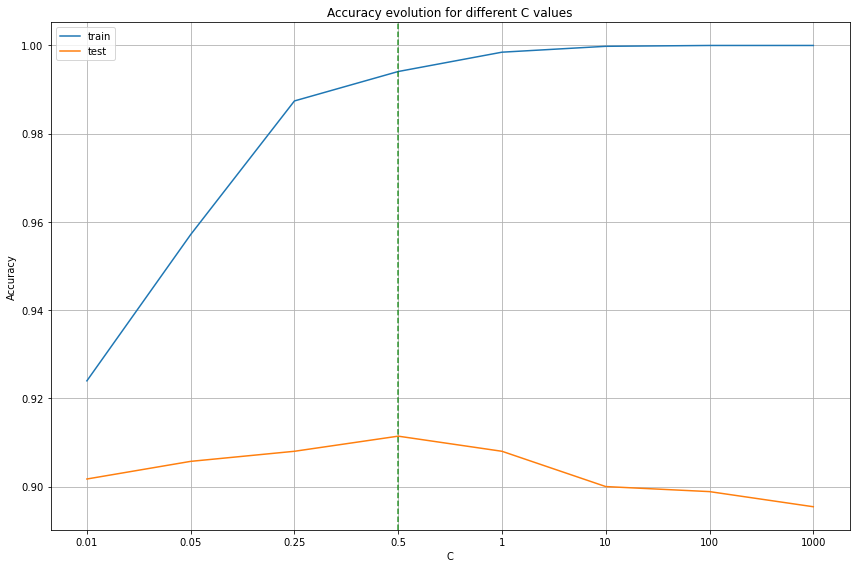

In [454]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [455]:
lr = LogisticRegression(C=0.5, solver='lbfgs', max_iter=500)
lr.fit(X_train_cv, y_train)
y_pred_cv = lr.predict(X_test_cv)

In [456]:
print('CountVectorizer simple\n')
print(confusion_matrix(y_test, y_pred_cv))
print(classification_report(y_test, y_pred_cv))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_cv)))

CountVectorizer simple

[[  44  123]
 [  32 1551]]
              precision    recall  f1-score   support

         neg       0.58      0.26      0.36       167
         pos       0.93      0.98      0.95      1583

    accuracy                           0.91      1750
   macro avg       0.75      0.62      0.66      1750
weighted avg       0.89      0.91      0.90      1750

Accuracy score:0.9114285714285715


No conseguimos mejorar.

Vamos a probar con TF-IDF Vectorizer a ver si lo mejoramos.

In [457]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [458]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_tfidf, y_train)
    
    train_predict = lr.predict(X_train_tfidf)
    test_predict = lr.predict(X_test_tfidf)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9045714285714286
Accuracy for C=0.05: 0.9045714285714286
Accuracy for C=0.25: 0.9045714285714286
Accuracy for C=0.5: 0.9045714285714286
Accuracy for C=1: 0.9051428571428571
Accuracy for C=10: 0.9142857142857143
Accuracy for C=100: 0.9097142857142857
Accuracy for C=1000: 0.9085714285714286


In [459]:
lr = LogisticRegression(C=10, solver='lbfgs', max_iter=500)
lr.fit(X_train_tfidf, y_train)
y_pred_tfid = lr.predict(X_test_tfidf)

In [460]:
print('CountVectorizer simple\n')
print(confusion_matrix(y_test, y_pred_tfid))
print(classification_report(y_test, y_pred_tfid))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_tfid)))

CountVectorizer simple

[[  29  138]
 [  12 1571]]
              precision    recall  f1-score   support

         neg       0.71      0.17      0.28       167
         pos       0.92      0.99      0.95      1583

    accuracy                           0.91      1750
   macro avg       0.81      0.58      0.62      1750
weighted avg       0.90      0.91      0.89      1750

Accuracy score:0.9142857142857143


Con este modelo hemos mejorado sensiblemente la precisión en las predicciones negativas.

Vamos a probar con otra extracción de características pero con este mismo TF-IDF Vectorizer a ver si lo mejoramos.

In [461]:
tfidf = TfidfVectorizer(ngram_range=(1, 4), max_features=5000, max_df=0.9, min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [462]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000, 100000, 1000000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_tfidf, y_train)
    
    train_predict = lr.predict(X_train_tfidf)
    test_predict = lr.predict(X_test_tfidf)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9045714285714286
Accuracy for C=0.05: 0.9045714285714286
Accuracy for C=0.25: 0.9045714285714286
Accuracy for C=0.5: 0.9045714285714286
Accuracy for C=1: 0.9045714285714286
Accuracy for C=10: 0.9205714285714286
Accuracy for C=100: 0.9142857142857143
Accuracy for C=1000: 0.9114285714285715
Accuracy for C=10000: 0.9074285714285715
Accuracy for C=100000: 0.9057142857142857
Accuracy for C=1000000: 0.9062857142857143


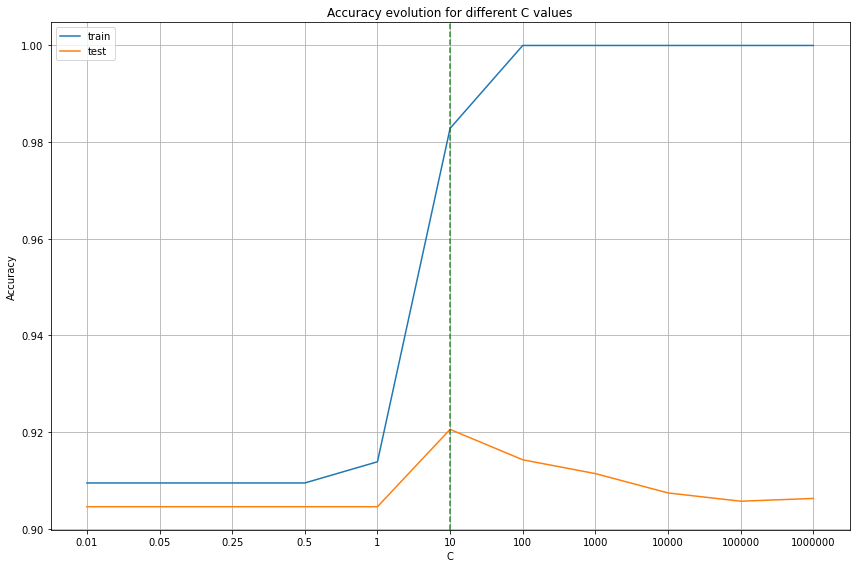

In [463]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [464]:
lr = LogisticRegression(C=10, solver='lbfgs', max_iter=500)
lr.fit(X_train_tfidf, y_train)
y_pred_tfid = lr.predict(X_test_tfidf)

In [465]:
print('CountVectorizer simple\n')
print(confusion_matrix(y_test, y_pred_tfid))
print(classification_report(y_test, y_pred_tfid))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_tfid)))

CountVectorizer simple

[[  36  131]
 [   8 1575]]
              precision    recall  f1-score   support

         neg       0.82      0.22      0.34       167
         pos       0.92      0.99      0.96      1583

    accuracy                           0.92      1750
   macro avg       0.87      0.61      0.65      1750
weighted avg       0.91      0.92      0.90      1750

Accuracy score:0.9205714285714286


Hemos mejorado bastante el accuracy, ya llegamos a una precisión del 92% en positivas y del 82% en negativas.

Vamos a utilizar el test de chi cuadrado para ver que palabras tienen mas score en nuestro set de entrenamiento.

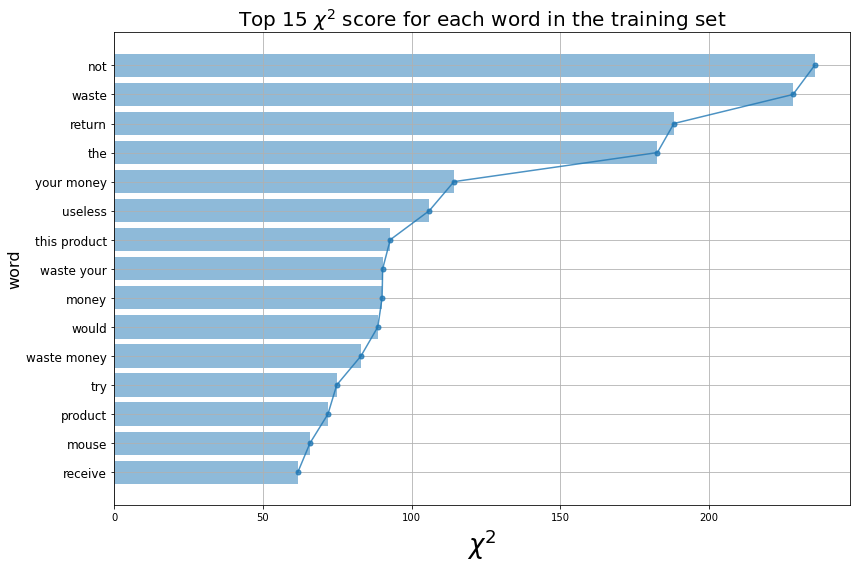

In [466]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_cv, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

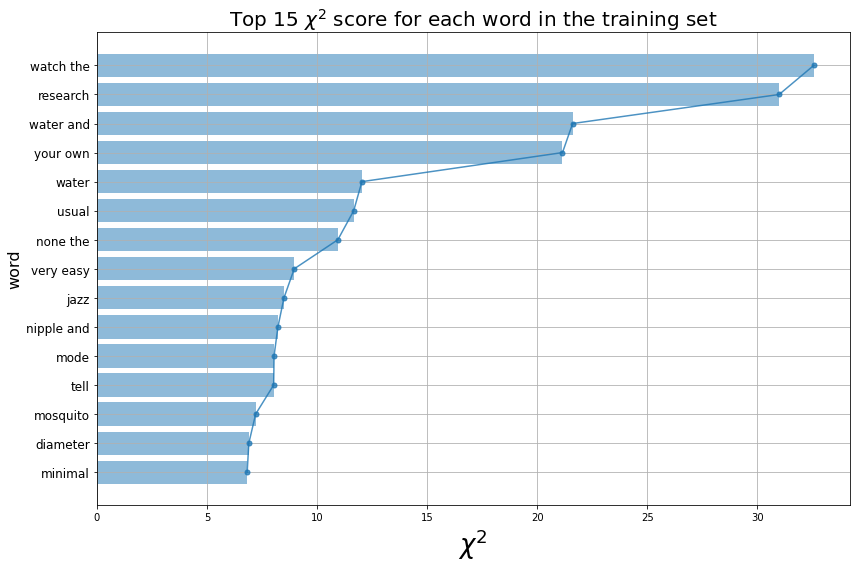

In [467]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_tfidf, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Hay tokens que se ve claramente que pueden ayudar a la clasificación como not (si hubieramos usado stopwords habría desaparecido), your money, useless, none the, very easy, usual...

Finalmente hemos conseguido una precisión bastante buena, pero teniendo en cuenta que estamos usando un problema binario (que es mas sencillo) si ya tuvieramos otra categoría de opniones neutras o incluso que predecir el número de estrellas sería más complicado.